In [116]:
import pandas as pd
df=pd.read_csv("auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [117]:
df.shape

(398, 9)

In [118]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [119]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [120]:
df.duplicated().sum()

np.int64(0)

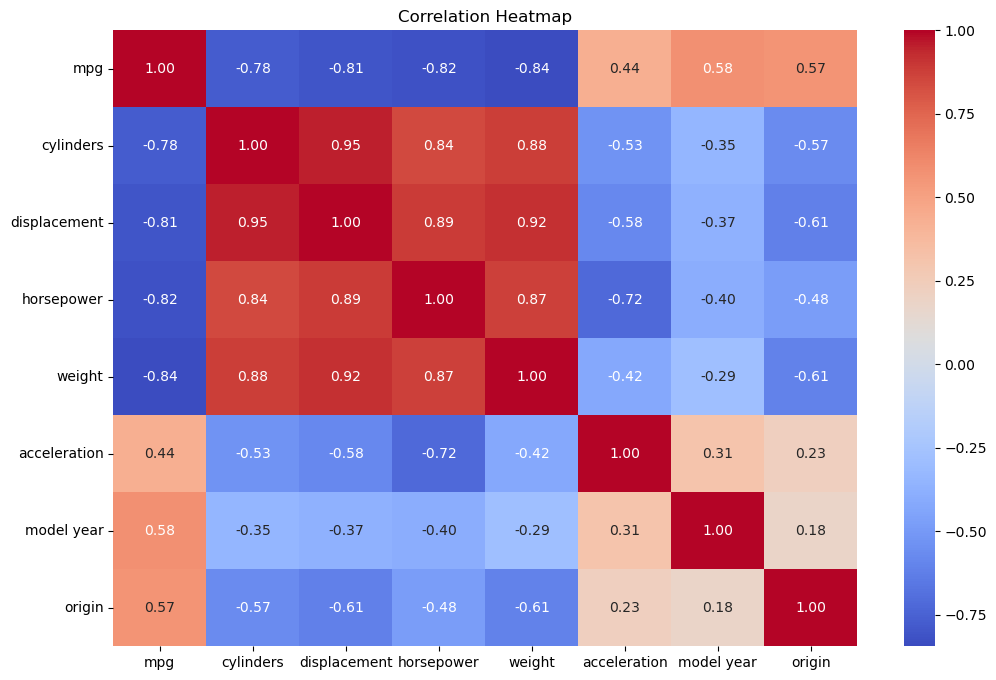

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df_log = df_log.drop(columns=['car name'], errors='ignore')  # in case it still exists


df_log['horsepower'] = pd.to_numeric(df_log['horsepower'], errors='coerce')
df_log = df_log.dropna()

corr = df_log.corr()


plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle


df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df.dropna(inplace=True)

df_log = df.copy()
for col in ['horsepower', 'weight', 'acceleration']:
    df_log[col] = np.log1p(df_log[col])


X = df_log[['horsepower', 'weight', 'acceleration', 'model year', 'origin']]
y = df['mpg']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel='rbf'),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse')
}


results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print("Model comparison:\n", results_df)


best_model_name = results_df.index[0]
best_model = models[best_model_name]
pickle.dump(best_model, open("best_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

print(f"\nBest model saved: {best_model_name}")


Model comparison:
                        MSE      RMSE        R2
RandomForest      5.326611  2.307945  0.895640
XGBoost           6.000177  2.449526  0.882443
GradientBoosting  6.632429  2.575350  0.870056
DecisionTree      6.848987  2.617057  0.865813
KNN               7.239722  2.690673  0.858158
SVR               8.863859  2.977223  0.826337
Lasso             9.342803  3.056600  0.816953
Ridge             9.631476  3.103462  0.811298
LinearRegression  9.645430  3.105709  0.811024

Best model saved: RandomForest


In [123]:
import pickle


pickle.dump(best_model, open("best_model.pkl", "wb"))

pickle.dump(scaler, open("scaler.pkl", "wb"))


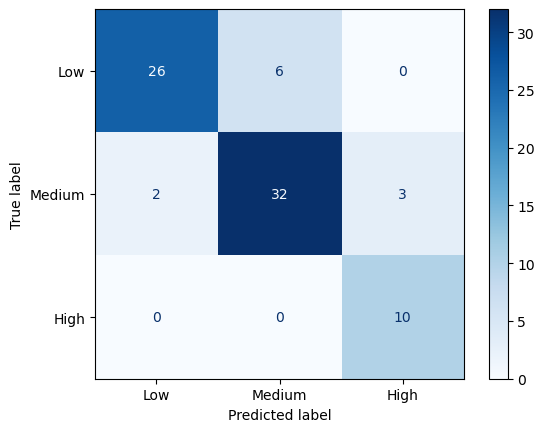

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

bins = [0, 20, 30, df['mpg'].max()]
labels = ['Low', 'Medium', 'High']
y_test_cat = pd.cut(y_test, bins=bins, labels=labels)

y_pred_cat = pd.cut(best_model.predict(X_test_scaled), bins=bins, labels=labels)


cm = confusion_matrix(y_test_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


Best Model: RandomForest
MSE: 5.327
RMSE: 2.308
R² Score: 0.896


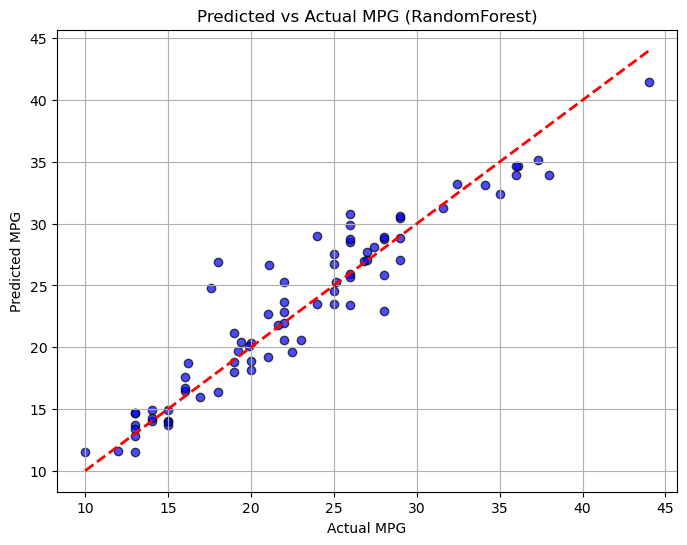

In [126]:

y_pred_best = best_model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)

print(f"Best Model: {best_model_name}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title(f"Predicted vs Actual MPG ({best_model_name})")
plt.grid(True)
plt.show()


